# QRT ENS Data Challenge 2023
## Data Specs (Copied from Official)
- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.

Input data sets comprise 35 columns:

ID: Unique row identifier, associated with a day (DAY_ID) and a country (COUNTRY),

DAY_ID: Day identifier - dates have been anonymized, but all data corresponding to a specific day is consistent,

COUNTRY: Country identifier - DE = Germany, FR = France,
and then contains daily commodity price variations,

GAS_RET: European gas,

COAL_RET: European coal,

CARBON_RET: Carbon emissions futures,

#### Weather measures (daily, in the country x)

x_TEMP: Temperature,

x_RAIN: Rainfall,

x_WIND: Wind,


#### Energy production measures (daily, in the country x)

x_GAS: Natural gas,

x_COAL: Hard coal,

x_HYDRO: Hydro reservoir,

x_NUCLEAR: Daily nuclear production,

x_SOLAR: Photovoltaic,

x_WINDPOW: Wind power,

x_LIGNITE: Lignite,

#### Electricity use metrics (daily, in the country x)

x_CONSUMPTON: Total electricity consumption,

x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,

x_NET_IMPORT: Imported electricity from Europe,

x_NET_EXPORT: Exported electricity to Europe,

DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,

FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.

Output data sets are composed of two columns:

ID: Unique row identifier - corresponding to the input identifiers,

TARGET: Daily price variation for futures of 24H electricity baseload.

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder as onehot
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import xgboost as xgb
import lightgbm as lgb
from itertools import product
from scipy import signal
from utils import *

In [2]:
df = pd.read_csv('x_train.csv').set_index('ID').sort_index()
y = pd.read_csv('y_train.csv').set_index('ID').sort_index()
true_test = pd.read_csv('x_test.csv').set_index('ID')
pd.set_option('display.max_columns', None)
de = df[df['COUNTRY'] == 'DE']
y_de = y[y.index.isin(de.index)]
fr = df[df['COUNTRY'] == 'FR']
y_fr = y[y.index.isin(fr.index)]

bx_train, bx_test, by_train, by_test = train_test_split(df, y, test_size=0.33, random_state=88)
df_numeric = df.drop(['DAY_ID', 'COUNTRY', 'FR_DE_EXCHANGE', 'FR_NET_EXPORT', 'DE_NET_EXPORT'], axis=1)
df_numeric = df_numeric.fillna(df_numeric.median(numeric_only=True))

<Axes: xlabel='ID', ylabel='FR_COAL'>

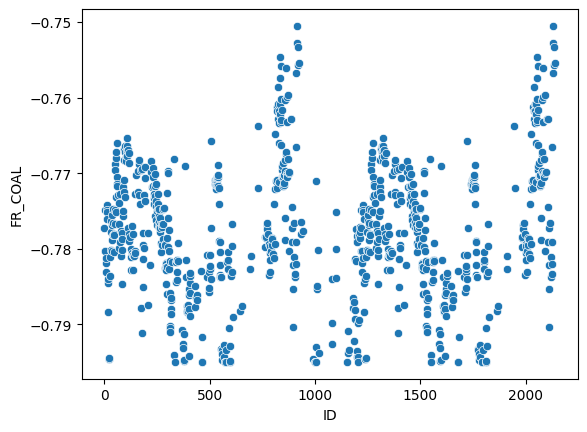

In [3]:
sns.scatterplot(x=df[df['FR_COAL'] < -0.75].index, y=df[df['FR_COAL'] < -0.75]['FR_COAL'])

<Axes: xlabel='ID', ylabel='DE_WIND'>

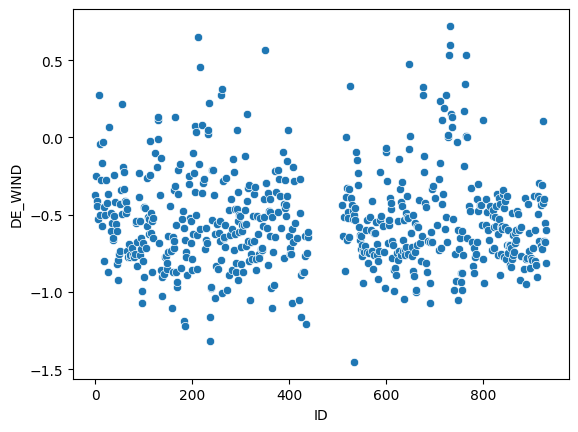

In [4]:
df_wind = de['DE_WIND'].copy()
left_mean = df_wind[df_wind.index < 450].mean()
left_std = df_wind[df_wind.index < 450].std()
df_wind[df_wind.index > 450] = (df_wind[df_wind.index > 450] - df_wind[df_wind.index > 450].mean()) / df_wind[df_wind.index > 450].std()
df_wind[df_wind.index > 450] = (df_wind[df_wind.index > 450] * left_std) + left_mean  
sns.scatterplot(x=df_wind.index, y=df_wind)

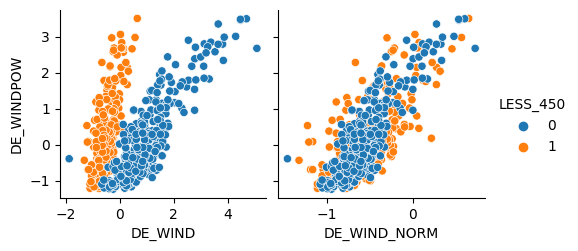

In [5]:
wind_norm = de[['DE_WIND', 'DE_WINDPOW']].copy()
wind_norm['DE_WIND_NORM'] = df_wind
wind_norm['LESS_450'] = 1
wind_norm.loc[wind_norm.index > 450, 'LESS_450'] = 0
sns.pairplot(data=wind_norm, x_vars=['DE_WIND', 'DE_WIND_NORM'], y_vars='DE_WINDPOW', hue='LESS_450')

<Axes: xlabel='ID', ylabel='FR_TEMP'>

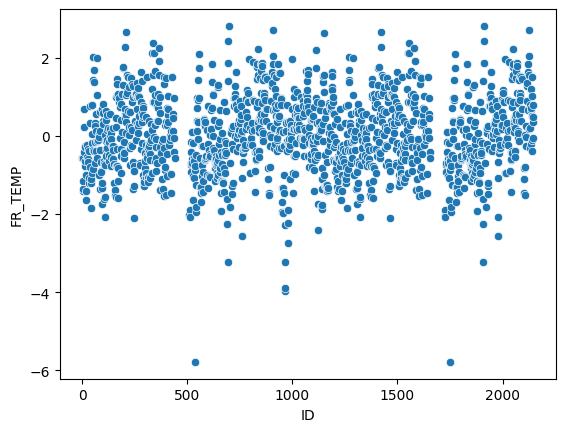

In [6]:
sns.scatterplot(x=df.index, y=df['FR_TEMP'])

<Axes: xlabel='ID', ylabel='DE_WIND'>

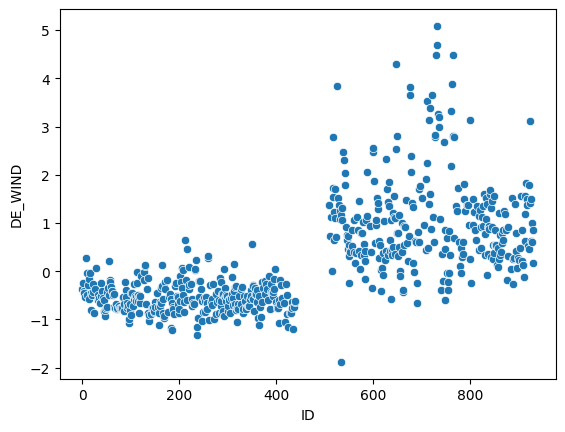

In [7]:
sns.scatterplot(x=de.index, y=de['DE_WIND'])

<Axes: xlabel='ID', ylabel='DE_WIND'>

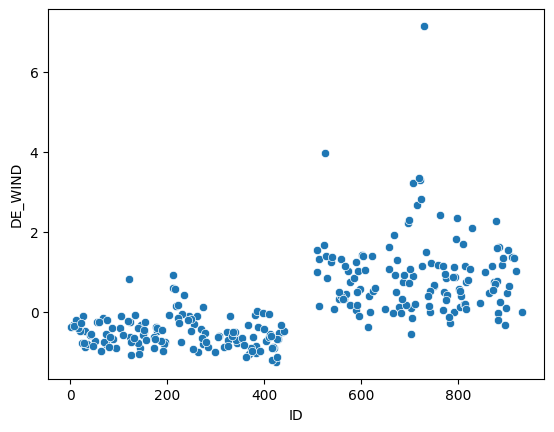

In [8]:
sns.scatterplot(x=true_test[true_test['COUNTRY'] == 'DE'].index, y=true_test[true_test['COUNTRY'] == 'DE']['DE_WIND'])

<Axes: xlabel='ID', ylabel='FR_GAS'>

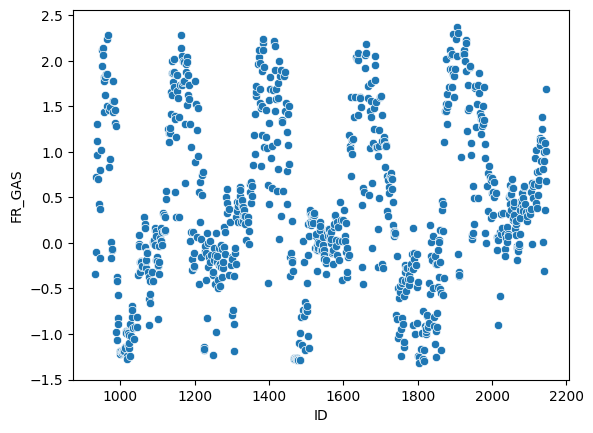

In [9]:
temp_fr = fr.copy()
temp_fr['TARGET'] = y_fr['TARGET']
sns.scatterplot(x=temp_fr.index, y=temp_fr['FR_GAS'])

In [10]:
both_fr = fr.append(true_test.loc[true_test['COUNTRY'] == 'FR'])
temp_fr = fr.copy()
temp_fr['FROM'] = 0
both_fr['FROM'] = 0
# both_fr.loc[true_test[true_test['COUNTRY'] == 'FR'].index, 'FROM'] = 1
temp_fr.loc[temp_fr['DE_FR_EXCHANGE'].isna(), 'FROM'] = 2
sns.scatterplot(x=temp_fr.index, y=temp_fr['DE_FR_EXCHANGE'], hue=both_fr['FROM'])

ValueError: array length 851 does not match index length 1216

In [ ]:
fs = np.linspace(0.1, 500, 1500)
for col in fr.drop(['DAY_ID', 'COUNTRY'], axis=1).columns:
    plt.figure()
    fig, axs = plt.subplots(2)
    
    pgram = signal.lombscargle(x=fr[col].dropna().index, y=fr[col].dropna(), freqs=fs)
    print([fs[i] for i in np.argwhere(pgram > 40).ravel()])
    p_fr = sns.lineplot(x=fs, y=pgram, ax=axs[0])
    p_fr.set(xlabel=f'{col} for FR')
    
    pgram = signal.lombscargle(x=de[col].dropna().index, y=de[col].dropna(), freqs=fs)
    print([fs[i] for i in np.argwhere(pgram > 40).ravel()])
    p_de = sns.lineplot(x=fs, y=pgram, ax=axs[1])
    p_de.set(xlabel=f'{col} for DE')
    
    plt.show()

In [ ]:
de.count()

In [ ]:
target.pivot_table(index='TARGET', aggfunc='size')[]

In [ ]:
target

In [ ]:
fourier_features(fuel_cost(enum_country(make_wind_sqcb(country_flow((basic_clean(df)))))))

In [ ]:
temp = fr[['GAS_RET', 'COAL_RET', 'CARBON_RET']].copy()
temp = temp.append(true_test.loc[true_test['COUNTRY'] == 'FR', ['GAS_RET', 'COAL_RET', 'CARBON_RET']]).sort_index()
gas = [0]
coal = [0]
carbon = [0]
prices = [gas, coal, carbon]
for row in temp.itertuples(index=False):
    for i in range(3):
        prices[i].append(prices[i][-1] + row[i])
for i in range(3):
    prices[i].pop(0)
plt.clf()
for p in prices:
    plt.figure()
    sns.lineplot(x=range(len(p)), y=p)

In [ ]:
energy = [0]
for row in y.itertuples(index=False):
    energy.append(energy[-1] + row[0])
energy.pop(0)
sns.lineplot(x=y.index, y=energy)

### Benchmarking
Running linear regression on the same train test split for a basic performance benchmark. For now we just replace NaN values with 0.

In [ ]:
br_lr = LinearRegression()

br_x_train_clean, br_x_test_clean = bx_train.fillna(0).drop(['DAY_ID', 'COUNTRY'], axis=1), bx_test.fillna(0).drop(['DAY_ID', 'COUNTRY'], axis=1)
y_train_clean, y_test_clean = by_train['TARGET'], by_test['TARGET']

test_model(br_lr, br_x_train_clean, br_x_test_clean, y_train_clean, y_test_clean)

### Feature Engineering

In [ ]:
km = KMeans(n_clusters=2)
km.fit(df_numeric)
km.labels_
df_clustered = df_numeric.copy()
df_clustered['CLUSTER'] = km.labels_
# sns.pairplot(data=df_clustered, vars=['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_IMPORT',
#       'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
#       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
#       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
#       'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND', 'FR_WIND',
#       'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET'], hue='CLUSTER')

In [ ]:
y

### Models

Trying various models.

TODO read through and implement stuff from here, paper notes that drivers of electricity prices are nonlinear: https://www.sciencedirect.com/science/article/pii/S0301421518307432

In [ ]:
x_fr = fuel_cost(make_wind_sqcb(country_flow((basic_clean(fr)))).drop('COUNTRY', axis=1))
x_de = fuel_cost(make_wind_sqcb(country_flow((basic_clean(de)))).drop('COUNTRY', axis=1))

In [ ]:
x = fourier_features(fuel_cost(enum_country(make_wind_sqcb(country_flow((drop_clean(de))))))) \
#    .drop(['DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO',
 #      'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR', 'GAS_RET', 'COAL_RET', 'DE_RAIN', 'FR_RAIN', 'DE_LIGNITE'], axis=1)
target = y
# x = x_fr
target = y_de[y_de.index.isin(x.index)]
# de: ridge alpha 40, xgb gamma 25

In [ ]:
x.columns

In [ ]:
#########################################################################################################
# x_train, x_test, y_train, y_test = x, df_test, y['TARGET'], None
#########################################################################################################

In [ ]:
# perform train test split after features have been calculated
x_train, x_test, y_train, y_test = train_test_split(x, target['TARGET'], test_size=0.33, random_state=88, shuffle=False)

In [ ]:
x_train = make_wind_excess(x, x_train.index, drop_windpow=False, use_iloc=False).loc[x_train.index]
x_test = make_wind_excess(x, x_train.index, drop_windpow=False, use_iloc=False).loc[x_test.index]

In [ ]:
x_train.columns

#### Baseline Linear Regression

In [ ]:
lr = LinearRegression()
train_result, test_result = test_model(lr, x_train, x_test, y_train, y_test)

#### Ridge Regression

In [ ]:
ridge = linear_model.Ridge(alpha=40)
train_result, test_result = test_model(ridge, x_train, x_test, y_train, y_test, print_output=False, graph_residuals=True)

#### XGB Regression

In [ ]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=25)
train_result, test_result = test_model(xgb_model, x_train, x_test, y_train, y_test, print_output=False, graph_residuals=False)

In [ ]:
kf = KFold(n_splits = 10, shuffle=True)
kf_test_model(kf, xgb_model, x, target)

#### Ridge Regression - XGB Hybrid

In [ ]:
ridge = linear_model.Ridge(alpha=5)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=5)
train_result, test_result = test_model(ridge, x_train, x_test, y_train, y_test, model_1=xgb_model, detailed=True, print_output=False, graph_residuals=True)

#### MLP Regressor

In [ ]:
mlpr = MLPRegressor(alpha=0.01, solver='lbfgs', hidden_layer_sizes=(50, 20))
train_result, test_result = test_model(mlpr, x_train, x_test, y_train, y_test)

#### MLP Regressor - XGB Hybrid

In [ ]:
x_train_lag = x_train.copy()
x_test_lag = x_test.copy()

In [ ]:
x_train_lag

In [ ]:
mlpr = MLPRegressor(alpha=0.01, solver='lbfgs', hidden_layer_sizes=(50, 20))
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=25)
train_result, test_result = test_model(mlpr, x_train, x_test, y_train, y_test, model_1=xgb_model, detailed=True, print_output=False, graph_residuals=True)

In [ ]:
kf = KFold(n_splits = 10)
kf_test_model(kf, mlpr, x, target, xgb_model)

### Submission

Make sure to change x_train and x_test to be the proper sets